# Stimmungsanalyse für IMDB-Kommentare (Basic LSTM Model)

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [2]:
# Load the data
train_df = pd.read_csv('preprocessed/train.csv')
val_df = pd.read_csv('preprocessed/val.csv')
test_df = pd.read_csv('preprocessed/test.csv')


Wir verwenden den `Tokenizer` von keras, um die Textdaten zu tokenisieren. 

In [3]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(train_df['review'])

X_train = tokenizer.texts_to_sequences(train_df['review'])
X_val = tokenizer.texts_to_sequences(val_df['review'])
X_test = tokenizer.texts_to_sequences(test_df['review'])

Hyperparameter:

In [4]:
max_words = 100000
embedding_dim = 32
lstm_units = 64
dropout_rate = 0.5
batch_size = 128
epochs = 10

Nach der Tokenisierung der Textdaten werden die Sequenzen so aufgefüllt, dass sie eine feste Länge von 500 haben.

In [5]:
# Pad the sequences to a fixed length
X_train = pad_sequences(X_train, maxlen=500)
X_val = pad_sequences(X_val, maxlen=500)
X_test = pad_sequences(X_test, maxlen=500)


Das Label extrahiert und in Numpy-Arrays umgewandelt.

In [6]:
# Convert target variable to numpy arrays
y_train = np.array(train_df['sentiment'])
y_val = np.array(val_df['sentiment'])
y_test = np.array(test_df['sentiment'])


Wir definieren eine LSTM-Modellarchitektur, um eine Stimmungsanalyse der tokenisierten  Textdaten durchzuführen. Das Model wird mit  "Sequential" von Keras erstellt.

In [7]:
from tensorflow.keras.layers import SpatialDropout1D

# Define the LSTM model architecture
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=500))
model.add(SpatialDropout1D(dropout_rate))
model.add(LSTM(lstm_units, dropout=0.4, recurrent_dropout=dropout_rate))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),  #to stop when no improvement is beeing made
    ModelCheckpoint(filepath='models/lstm_model_100000.h5', save_best_only=True) # to save the model
]


Epoch 1/10
272/272 [==============================] - 302s 1s/step - loss: 0.4378 - accuracy: 0.7804 - val_loss: 0.2804 - val_accuracy: 0.8871
Epoch 2/10
272/272 [==============================] - 266s 977ms/step - loss: 0.2532 - accuracy: 0.9008 - val_loss: 0.2673 - val_accuracy: 0.8980
Epoch 3/10
272/272 [==============================] - 260s 954ms/step - loss: 0.1933 - accuracy: 0.9272 - val_loss: 0.2833 - val_accuracy: 0.8984
Epoch 4/10
272/272 [==============================] - 260s 955ms/step - loss: 0.1526 - accuracy: 0.9434 - val_loss: 0.2675 - val_accuracy: 0.8962
Epoch 5/10
233/233 [==============================] - 16s 70ms/step - loss: 0.2690 - accuracy: 0.8970
Test accuracy: 0.8970015048980713


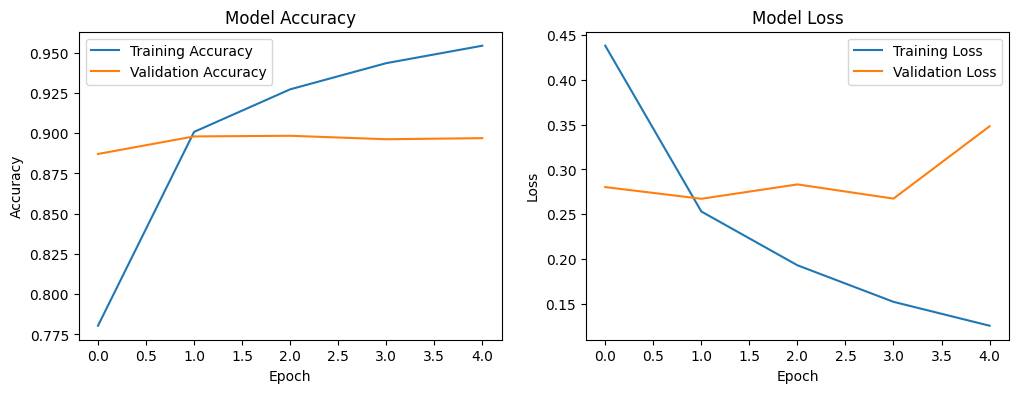

In [8]:

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=batch_size, epochs=epochs, callbacks=callbacks)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()


Das LSTM-Model hat immernoch mit Overfitting zu kämpfen, hat aber mit einer Test Accuracy von 89,49 % den besten Wert. Deshalb wird im folgendem das Model zur Klassifizierung eigener Bewertungen im String Format verwendet

In [9]:
from tensorflow.keras.models import load_model

# Define hyperparameters
max_words = 100000
max_len = 500

# Load the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['review'])

# Load the model
model = load_model('models/lstm_model_100000.h5')

# Define a function to classify sentiment
def classify_sentiment(review):
    # Convert the input review to a sequence of integer indices
    sequence = tokenizer.texts_to_sequences([review])
    # Pad the sequence to a fixed length
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    # Predict the sentiment
    prediction = model.predict(padded_sequence)[0][0]
    if prediction > 0.5:
        return 'positive'
    else:
        return 'negative'


In [10]:
review = "This is something I haven't seen in years! It's exactly what a die hard horror movie fan needs. The exorcist, The Exorcism of Emily Rose just w/o the priests. This movie deserves all the hype! I didn't experience this type of scary in a very very long time! It keeps you on the edge of your seat and makes you want to look away till you just want to get out of the theater and go home, highly recommend just be prepared to take it home with you haha."
sentiment = classify_sentiment(review)
print(sentiment)

1/1 [==============================] - 0s 268ms/step
positive


In [11]:
review = """This movie is just pooh pooh. It is not funny. There a scene with man taking a pooh pooh on a floor. And that is proof that is not funny it is just pooh pooh. The story is line awful. The acting is awful. The humor is awful. There are a lot of comedy movies that are not funny. They are just pooh pooh and this is one them. A couple by a haunted house. It is supposed to be funny but it is just pooh pooh. The Wayans brother have no talent. There are not funny. There do not know how to be funny. There movie to prove the comedy is easy. Do not wast you time. Do not wast your money do not see this awful pooh pooh of a movie. This is one of the worst comedies from 2013. It is not funny at all."""
sentiment = classify_sentiment(review)
print(sentiment)

1/1 [==============================] - 0s 42ms/step
negative
